<a href="https://colab.research.google.com/github/raneldan/ImageDetection/blob/main/eigenFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code requier connection to google drive
Need to provide 2 folders:
1) dataset - this folder should contain folders of picture of people. The name of the folder should be it's tag (= name).
2) Classify - this folder should contain .jpg files which we want to detect faces in and classify them based on the dataset from 1) 

In [ ]:
# Download the test image and utils files
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/test.jpg \
    -O test.jpg
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/utils/common.py \
    -O common.py

--2021-06-14 20:28:39--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240458 (235K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 234.82K  --.-KB/s    in 0.03s   

2021-06-14 20:28:40 (8.36 MB/s) - ‘test.jpg’ saved [240458/240458]

--2021-06-14 20:28:40--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awai

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


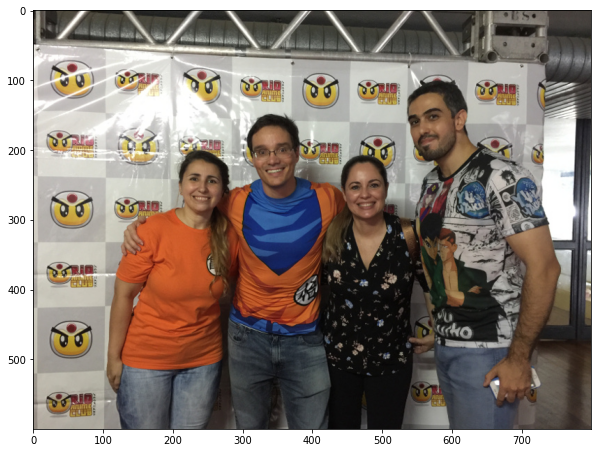

In [ ]:

# these imports let you use opencv
import cv2 #opencv itself
from google.colab.patches import cv2_imshow
import common #some useful opencv functions
import numpy as np # matrix manipulations
from skimage import io
import glob
import os
from google.colab import drive

drive.mount('/content/gdrive')


#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

# Load the test image and create a greyscale copy of it to be used in the classifiers

base_image = cv2.imread('test.jpg')
grey = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))

In [ ]:
def detectFaces(pathToImage):
  resultFaces = []
  image = loadImage(pathToImage)
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(image, 1.3, 5)
  for face in faces:
    resultFaces.append(image[face[1]:face[1]+250, face[0]:face[0]+250])
  return resultFaces

In [ ]:
def loadImage(url):
  # load image 
  image = io.imread(url) 

  # convert the image to gray level
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image

In [ ]:
def showImage(image):
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def meanFace(dataset):
  commulative = np.array([])
  size = 0
  for imageNum,image in enumerate(dataset):
    image = image.flatten()
    size = image.shape
    for index,pixel in enumerate(image):
      if (imageNum == 0):
        commulative = np.append(commulative,pixel)
      else:
        commulative[index] += pixel
  return commulative/size


In [ ]:
def createDataSet(path):
  dataset = []
  tags = []
  dirs = [path + '/' + x for x in os.listdir(path)]
  for dir in dirs:
    if (os.path.isdir(dir)):
      files = [dir + '/' + x for x in os.listdir(dir)]
      for file in files:
        if file.endswith(".jpg"):
          dataset.append(loadImage(file))
          tags.append(file)
  return ([dataset, tags])

In [ ]:
def displayMeanFace(commArr):
  avargeFace = commArr.reshape(250,250)
  plt.imshow(avargeFace)

In [ ]:
def eigenVectorsMatrix(dataset, meanFace):
  matrix = np.empty((62500,len(dataset)))
  for imageNum,image in enumerate(dataset):
    image = image.flatten()
    for index,pixel in enumerate(image):
      matrix[index][imageNum] = abs(pixel-meanFace[index])
  return np.mat(matrix.T) * np.mat(matrix)

In [ ]:
def projectToEigenFaces(image, meanFace, eigenMat):
  newImage = np.empty(eigenMat.shape[0])
  image = np.array(image)
  image = image.flatten().astype(np.float64)
  image -= meanFace
  image = image.reshape(62500,1)[0]
  for index,col in enumerate(eigenMat.T):
    col = np.array(col).reshape(-1,1)
    col = col[0]
    newImage[index] = np.multiply(image, col.T)
  return newImage

In [ ]:
def createDatasetCoordinates(dataset, meanFace, eigenMat):
  datasetCoordinates = []
  for image in dataset:
    datasetCoordinates.append(projectToEigenFaces(image, meanFace, eigenMat)) 
  return datasetCoordinates

In [ ]:
def findDistanceBetweenFaces(firstFace, secondFace):
  disatnce = 0
  for firstCoor,secondCoord in zip(firstFace, secondFace):
    disatnce += abs(firstCoor - secondCoord)
  return disatnce

In [ ]:
def findClosestFaceInDataset(datasetCoor, tags, face):
  minDistanceFace = float("inf")
  resultIndex = -1
  for index,item in enumerate(datasetCoor):
    distance = findDistanceBetweenFaces(item, face)
    if (distance < minDistanceFace):
      minDistanceFace = distance
      resultIndex = index
  return [tags[resultIndex], minDistanceFace]

In [ ]:
def classifyNewFace(image, avargeFace, eigenMat, datasetCoor, tags):
  vector = projectToEigenFaces(image, avargeFace, eigenMat)
  return(findClosestFaceInDataset(datasetCoor, tags, vector))

In [ ]:
def classifyFaces(path, avargeFace, eigenMat, datasetCoor, tags):
  results = []
  dir = [path + '/' + x for x in os.listdir(path)]
  for file in dir:
      if file.endswith(".jpg"):
        print("image to classify : " + file)
        faces = detectFaces(file)
        for face in faces:
          showImage(face)
          results.append(classifyNewFace(face, avargeFace, eigenMat, datasetCoor, tags))
  return results


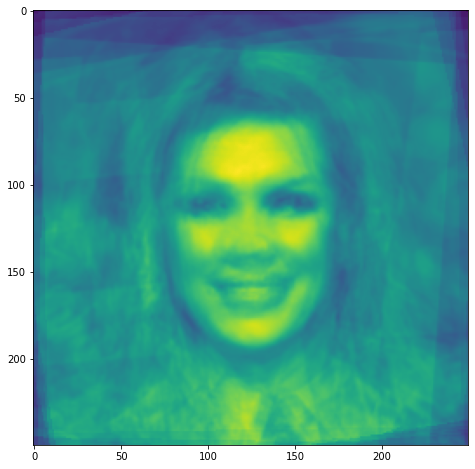

In [ ]:
[dataset, tags] = createDataSet('/content/gdrive/MyDrive/Colab Notebooks/dataset')
avargeFace = meanFace(dataset)
displayMeanFace(avargeFace)
eigenMat = eigenVectorsMatrix(dataset, avargeFace)
datasetCoor = createDatasetCoordinates(dataset, avargeFace, eigenMat)

image to classify : /content/gdrive/MyDrive/Colab Notebooks/Classify/bill.jpg
face to classify : 
face to classify : 
result is: /content/gdrive/MyDrive/Colab Notebooks/dataset/Catherine_Zeta-Jones/Catherine_Zeta-Jones_0001.jpg distance is: 22655053873.20659
result is: /content/gdrive/MyDrive/Colab Notebooks/dataset/Britney_Spears/Britney_Spears_0007.jpg distance is: 83068530868.42415


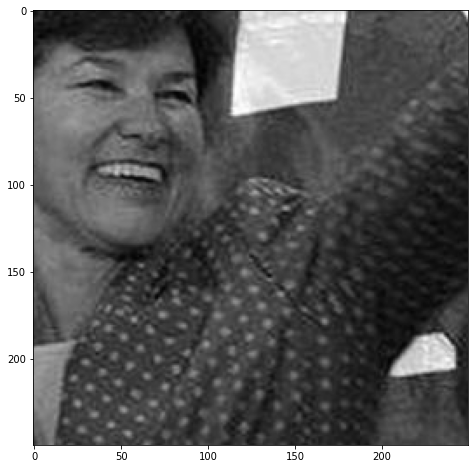

In [ ]:
faces = classifyFaces('/content/gdrive/MyDrive/Colab Notebooks/Classify', avargeFace, eigenMat, datasetCoor, tags)
for face in faces:
  print("result is: " + face[0].__str__() + " distance is: " + face[1].__str__())

In [ ]:
##results = classifyFaces('/content/gdrive/MyDrive/Colab Notebooks/Classify', avargeFace, eigenMat, datasetCoor, tags)
#for result in results:
#  print("result is: " + result[0].__str__() + " distance is: " + result[1].__str__())